In [ ]:
# Устанавливаем библиотеку, в процессе выполнения лабораторной работы она нам будет необходима.
!pip install kneed

## Лабораторная работа №5

$\textit{Выполнил: Новицкий Никита}$

$\textit{Группа: 6132-010402D}$

## Задание 

Выполните кластеризацию данных вашего варианта с использованием K-Means и его "мягкой" версии. Найдите количество кластеров, которое дает наибольшую чистоту, используйте различные показатели расстояния: евклидово расстояние, манхэттенское расстояние, расстояние Чебышева. Постройте графики значений чистоты и DBI в зависимости от "K" (количества кластеров) для каждой из метрик расстояния.

## Импортируем необходимые библиотеки для реализации лабораторной работы

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
from scipy.spatial.distance import euclidean
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")

In [2]:
def create_data(npy):
    """
    Данная функция создаст нам dataframe, который
    будет использоваться для кластеризации с помощью K-Means/Soft K-Means
    """
    X, Y, Z = [], [], []
    for z in range(npy.shape[0]):
        for y in range(npy.shape[1]):
            for x in range(npy.shape[2]):
                X.append(x)
                Y.append(y)
                Z.append(z)
    return pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

In [3]:
%%time
npy = np.load("/Users/nvnovitskiy/Downloads/10.npy")
print(f"Размерность данных: {npy.shape}")

Размерность данных: (512, 512, 237)
CPU times: user 783 µs, sys: 16.1 ms, total: 16.9 ms
Wall time: 18 ms


In [4]:
%%time
df = create_data(npy)
print(f"Размерность данных после создания DataFrame: {df.shape}")

Размерность данных после создания DataFrame: (62128128, 3)
CPU times: user 37.6 s, sys: 2.75 s, total: 40.4 s
Wall time: 40.4 s


In [5]:
df.head()

,X,Y,Z
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


Так как в данных нет лейблов, то в рамках лабораторной работы я буду использовать только внутреннюю метрику, а то есть  индекс Дэвиса–Болдина. Относительно его значения и будет выбираться оптимальное количество кластеров, стоит отметить, что на такой выборке (62128128) вычисления довольно трудозатратны и по времени, и по RAM (нужен компьютер минимум с 16 GB RAM ), поэтому я взял 1/62 часть выборки для кластеризации, чтобы не ждать $\infty$.

In [6]:
X = shuffle(df[:1128128].to_numpy())

In [7]:
X[:5]

array([[ 37,  49,   2],
       [ 94, 101,   5],
       [109, 364,   7],
       [ 47,   9,   5],
       [101, 241,   2]])

In [8]:
def cluster_resp(distances):
    """
    Функция для вычисления значения принадлежности точек кластерам.
    
    Чем больше расстояние до кластер "к" - тем менее важна данная точка для кластера "к"
    Обратите внимание, данная функция очень похожа на функцию "softmax"
    """
    d_exp = np.exp(-distances)
    return d_exp / np.sum(d_exp, axis=1, keepdims=True)

In [9]:
def loss(X, M, R, dist_type):
    """
    Другой способ измерения качества результатов кластеризации
    Постарайтесь самостоятельно понять значение этой функции
    Эта метрика может быть использована в качестве критерия остановки алгоритма
    """
    loss = 0
    for k in range(len(M)):
        d = dist(X, M[k],dist_type)
        loss += np.sum(R[:, k] * d * d)
    return loss

In [10]:
def dist(x, y, dist_type):
    """
    Данная функция служит для выбора определенной distance метрики.
    """
    if dist_type == "euclidian":
        diff = x - y
        dist = np.sqrt(np.sum(diff * diff, axis=-1))
    if dist_type == "manhattan":
        diff = x - y
        dist = np.sum(np.abs(diff), axis=-1)
    if dist_type == "chebyshev":
        diff = x - y
        dist = np.max(np.abs(diff), axis=-1)
    return dist

K-Means - это классический алгоритм кластеризации. Где `K` - количество класстеров и `means` означает что центр кластера - это центральная точка кластера. Далее перечислим шаги алгоритма:

1. Случайным образом инициализировать `K` центров кластеров.
2. Кластеризуем (разметим) данные согласно текущим кластерам.
3. Пересчитаем центры кластеров.
4. Повторять шаги 2 и 3 пока алгоритм не сойдется. 

Алгоритм сошелся если центры кластеров не изменились.


In [11]:
def k_means(X, K, max_iter=15, max_attempts=10, dist_type = "euclidian"):
    N, D = X.shape
    L = np.zeros(N)
    M = np.zeros((K, D))
    
    for at in range(max_attempts):
        for k in range(K):
            M[k] = X[np.random.choice(N)]

        for i in range(max_iter):
            dists = []
            for k in range(K):
                dists += [dist(X, M[k], dist_type).reshape(-1, 1)]
            dists = np.hstack(dists)
            L = np.argmin(dists, axis=1)

            for k in range(K):
                M[k] = X[L==k].mean(axis=0)

        if(len(np.unique(L))) == K:
                break            
        if i == (max_attempts-1):
            print("max_attempts achived, try take another K")
            print("Current K", len(np.unique(L)))
    
    return M, L

Soft K-Means это модификация классического K-Means, которая позволяет оценить вероятность того, что точка принадлежит какому-то кластеру. Этот алгоритм также называется "нечеткой кластеризацией".

1. Случайным образом инициализировать `K` центров кластеров.
2. Вычислим значения принадлоежности точек кластерам. 
3. Пересчитаем центры кластеров в соответствии со значениями принадлежности кластерам.
4. Повторять шаги 2, 3 до схождения алгоритма. 

Алгоритм сошелся если центры кластеров не изменились (или изменились незначительно)

In [12]:
def soft_k_means(X, K, dist_type = "euclidian", max_iter=15):
    N, D = X.shape
    R = np.zeros((N, K))
    M = np.zeros((K, D))
    losses = []

    for k in range(K):
        M[k] = X[np.random.choice(N)]

    for i in range(max_iter):
        dists = []
        
        for m in range(K):
            dists += [dist(X, M[m], dist_type).reshape(-1, 1)]
        dists = np.hstack(dists)
        R = cluster_resp(dists)

        for k in range(K):
            M[k] = R[:, k].dot(X) / R[:, k].sum()
        losses.append(loss(X, M, R,dist_type))
        
    return M, R, losses

In [13]:
def metrics_davies_bouldin(X, cluster_labels, distance=euclidean):
    n_cluster = len(np.bincount(cluster_labels))
    cluster_k = [X[cluster_labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([distance(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []
    
    for i in range(n_cluster):
        for j in range(n_cluster):
            if (j != i) and (~np.isnan(centroids[i]).any() and ~np.isnan(centroids[j]).any()): 
                db.append((variances[i] + variances[j]) / distance(centroids[i],centroids[j]))

    return(np.max(db)/n_cluster)

## Расчет метрик и нахождение оптимального значения K (K-Means)

In [14]:
start = 2 
stop = 30
euclidian_arr=np.zeros((stop, start))
manhattan_arr=np.zeros((stop, start))
chebyshev_arr=np.zeros((stop, start))

In [15]:
for i in tqdm(range(start, stop)):
    M, L = k_means(X, K=i, dist_type="euclidian")
    euclidian_arr[i] = i, metrics_davies_bouldin(X, L)

print("Евклидова метрика рассчитана.")

  0%|          | 0/28 [00:00<?, ?it/s]

Евклидова метрика рассчитана.


In [17]:
for i in tqdm(range(start, stop)):
    M, L = k_means(X, K = i, dist_type="manhattan")
    manhattan_arr[i] = i, metrics_davies_bouldin(X, L)  

print("Манхэттенская метрика рассчитана.")

  0%|          | 0/28 [00:00<?, ?it/s]

Манхэттенская метрика рассчитана.


In [19]:
for i in tqdm(range(start, stop)):
    M, L = k_means(X, K=i, dist_type="chebyshev")
    chebyshev_arr[i] = i, metrics_davies_bouldin(X, L) 

print("Чебышевская метрика рассчитана.")

  0%|          | 0/28 [00:00<?, ?it/s]

Чебышевская метрика рассчитана.


## Чтобы найти оптимальное K для каждой метрики, мы воспользуемся библиотекой kneed.

Репозиторий библиотеки на [github](https://github.com/arvkevi/kneed)

In [16]:
optimum_k_euclid = KneeLocator(
    euclidian_arr[start:, 0], 
    euclidian_arr[start:, 1], 
    curve='convex', 
    direction='decreasing'
).knee

print(f"Оптимальное значение K для Евклидовой метрики: {optimum_k_euclid}")

Оптимальное значение K для Евклидовой метрики: 5.0


In [18]:
optimum_k_manhattan = KneeLocator(
    manhattan_arr[start:, 0], 
    manhattan_arr[start:, 1], 
    curve='convex', 
    direction='decreasing'
).knee

print(f"Оптимальное значение K для Манхэттенской метрики: {optimum_k_manhattan}")

Оптимальное значение K для Манхэттенской метрики: 7.0


In [21]:
optimum_k_chebyshev = KneeLocator(
    chebyshev_arr[start:,0], 
    chebyshev_arr[start:,1], 
    curve='convex', 
    direction='decreasing'
).knee

print(f"Оптимальное значение K для Чебышевской метрики: {optimum_k_chebyshev}")

Оптимальное значение K для Чебышевской метрики: 8.0


## Визуализация метрик (K-Means)

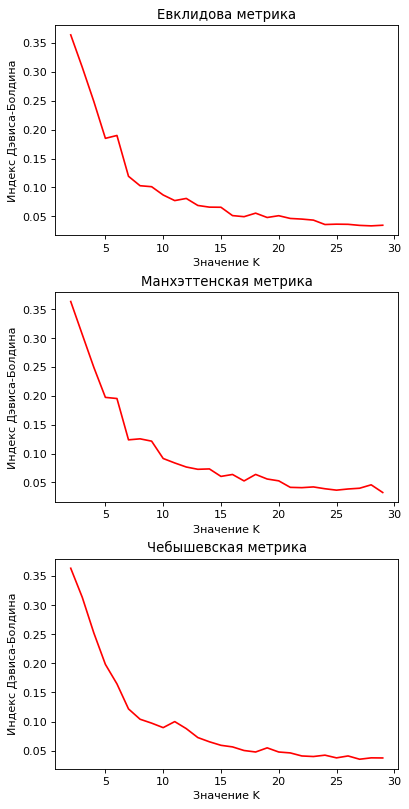

In [25]:
all_metrics = np.concatenate((euclidian_arr, manhattan_arr, chebyshev_arr), axis=1)
all_metrics = all_metrics[:, (0, 1, 3, 5)]
metric_names = ["Евклидова метрика","Манхэттенская метрика","Чебышевская метрика"]
fig, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(5, 10), dpi=80)

for x in range(3):
    ax[x].plot(all_metrics[start:, 0], all_metrics[start:, x + 1], color="red")
    ax[x].set_title(metric_names[x])
    ax[x].set_xlabel("Значение K")
    ax[x].set_ylabel("Индекс Дэвиса-Болдина")

## Расчет метрик и нахождение оптимального значения K (Soft K-Means)

In [26]:
start = 2 
stop = 30
euclidian_soft_arr=np.zeros((stop, start))
manhattan_soft_arr=np.zeros((stop, start))
chebyshev_soft_arr=np.zeros((stop, start))

In [27]:
for i in tqdm(range(start, stop)):
    M, R ,l = soft_k_means(X, K=i, dist_type = "euclidian")
    L_soft = np.argmax(R, axis=1)
    euclidian_soft_arr[i] = i, metrics_davies_bouldin(X, L_soft)

print("Евклидова метрика рассчитана.")

  0%|          | 0/28 [00:00<?, ?it/s]

Евклидова метрика рассчитана.


In [29]:
for i in tqdm(range(start, stop)):
    M, R ,l = soft_k_means(X, K = i, dist_type = "manhattan")
    L_soft = np.argmax(R, axis=1)
    manhattan_soft_arr[i] = i, metrics_davies_bouldin(X, L_soft)  
    
print("Манхэттенская метрика рассчитана.")

  0%|          | 0/28 [00:00<?, ?it/s]

Манхэттенская метрика рассчитана.


In [31]:
for i in tqdm(range(start, stop)):
    M, R, l = soft_k_means(X, K=i, dist_type = "chebyshev")
    L_soft = np.argmax(R, axis=1)
    chebyshev_soft_arr[i] = i, metrics_davies_bouldin(X, L_soft) 
    
print("Чебышевская метрика рассчитана.")

  0%|          | 0/28 [00:00<?, ?it/s]

Чебышевская метрика рассчитана.


## Чтобы найти оптимальное K для каждой метрики, мы воспользуемся библиотекой kneed.

Репозиторий библиотеки на [github](https://github.com/arvkevi/kneed)

In [28]:
optimum_k_soft_euclid = KneeLocator(
    euclidian_soft_arr[start:, 0], 
    euclidian_soft_arr[start:, 1], 
    curve='convex', 
    direction='decreasing'
).knee

print(f"Оптимальное значение K (Soft K-Means) для Евклидовой метрики: {optimum_k_soft_euclid}")

Оптимальное значение K (Soft K-Means) для Евклидовой метрики: 8.0


In [30]:
optimum_k_soft_manhattan = KneeLocator(
    manhattan_soft_arr[start:,0], 
    manhattan_soft_arr[start:,1], 
    curve='convex', 
    direction='decreasing'
).knee

print(f"Оптимальное значение K (Soft K-Means) для Манхэттенской метрики: {optimum_k_soft_manhattan}")

Оптимальное значение K (Soft K-Means) для Манхэттенской метрики: 8.0


In [32]:
optimum_k_soft_chebyshev = KneeLocator(
    chebyshev_soft_arr[start:,0], 
    chebyshev_soft_arr[start:,1], 
    curve='convex',
    direction='decreasing'
).knee

print(f"Оптимальное значение K (Soft K-Means) для Чебышевской метрики: {optimum_k_soft_chebyshev}")

Оптимальное значение K (Soft K-Means) для Чебышевской метрики: 7.0


## Визуализация метрик (Soft K-Means)

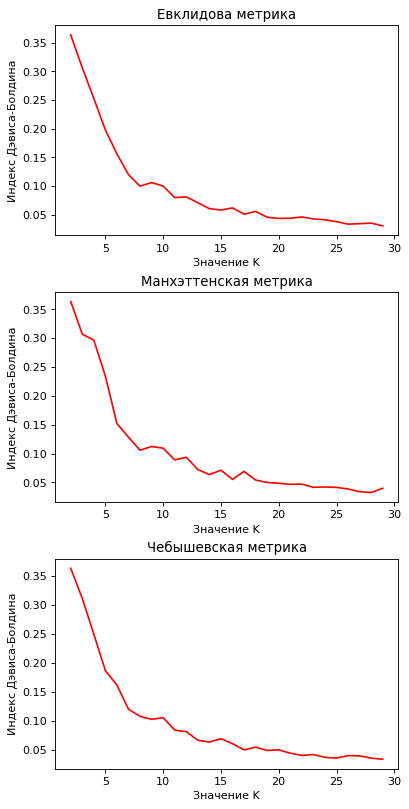

In [34]:
all_soft_metrics = np.concatenate((euclidian_soft_arr, manhattan_soft_arr, chebyshev_soft_arr), axis=1)
all_soft_metrics = all_soft_metrics[:, (0, 1, 3, 5)]
metric_names = ["Евклидова метрика","Манхэттенская метрика","Чебышевская метрика"]
fig, ax = plt.subplots(3, 1, constrained_layout=True,figsize=(5, 10), dpi=80)

for y in range(3):
    ax[y].plot(all_soft_metrics[start:, 0], all_soft_metrics[start:, y + 1], color="red")
    ax[y].set_title(metric_names[y])
    ax[y].set_xlabel("Значение K")
    ax[y].set_ylabel("Индекс Дэвиса-Болдина")

## Выводы по лабораторной работе

1) K-Means работает по-быстрее, чем Soft K-Means

2) С помощью библиотеки kneed есть возможность подбирать оптимальное значение K

3) Результат K-средних сильно зависит от начальных значений центров кластера.

4) Оптимальное значение K для K-Means в данной работе: [5, 7, 8], а для Soft K-Means: [8, 8, 7]